# LocALE: Learned Activation Functions for Location Encoding

**Goal**: Test if learned activation functions can replace spherical harmonics + SIREN

## Key Idea
SatCLIP uses:
- Spherical harmonics (L=10: 100 features, L=40: 1600 features) for positional encoding
- SIREN (sine activations) to process these features

We propose:
- Direct (lat, lon) input (no spherical harmonics)
- Learned activation functions that discover frequency structure from data
- Spatially-varying activations that adapt to local characteristics

## Experiments
1. **Baselines**: Direct + ReLU, Direct + SIREN, SatCLIP L=10, SatCLIP L=40
2. **Learned Activations**: Fourier-parameterized activation functions
3. **Spatially-Varying**: Mixture of expert activations based on location

## Evaluation
- Population density prediction at multiple scales
- Global vs Regional performance (our key finding: L=40 wins regionally)

In [1]:
# Setup
import os
import sys

if 'COLAB_GPU' in os.environ:
    !rm -rf sample_data .config satclip gpw_data 2>/dev/null
    !git clone https://github.com/1hamzaiqbal/satclip.git
    !pip install lightning torchgeo huggingface_hub rasterio --quiet

Cloning into 'satclip'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 457 (delta 202), reused 165 (delta 132), pack-reused 187 (from 2)
Receiving objects: 100% (457/457), 80.31 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (230/230), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 18.1 MB/s eta 0:00:00
   ━━━

In [2]:
# Mount Google Drive and extract GPW data
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

GPW_DIR = './gpw_data'
os.makedirs(GPW_DIR, exist_ok=True)

SOURCE_ZIP_PATH = '/content/drive/MyDrive/grad/learned_activations/dataverse_files.zip'

print("Extracting GPW data...")
with zipfile.ZipFile(SOURCE_ZIP_PATH, 'r') as z:
    z.extractall(GPW_DIR)

# Extract 15-min resolution (good balance of speed and detail)
zip_path = os.path.join(GPW_DIR, 'gpw-v4-population-density-rev11_2020_15_min_tif.zip')
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(GPW_DIR)
    print("Extracted 15-min resolution")

print("Done!")

Mounted at /content/drive
Extracting GPW data...
Extracted 15-min resolution
Done!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

if 'COLAB_GPU' in os.environ:
    sys.path.append('./satclip/satclip')
    GPW_DIR = './gpw_data'
else:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'satclip'))
    GPW_DIR = './gpw_data'

from huggingface_hub import hf_hub_download
from load import get_satclip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load SatCLIP models for comparison
print("Loading SatCLIP models...")
satclip_l10 = get_satclip(hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"), device=device)
satclip_l40 = get_satclip(hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"), device=device)
satclip_l10.eval()
satclip_l40.eval()
print("SatCLIP models loaded!")

Using device: cuda
Loading SatCLIP models...


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 208MB/s]


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
SatCLIP models loaded!


---
## 1. Learned Activation Functions

Instead of fixed ReLU or sine, we parameterize activations as Fourier series:

$$g_\psi(x) = \sum_{k=1}^{K} a_k \sin(\omega_k x) + b_k \cos(\omega_k x)$$

where $\omega_k$ are fixed frequencies and $\psi = \{a_k, b_k\}$ are learned.

Learned activation params: 52


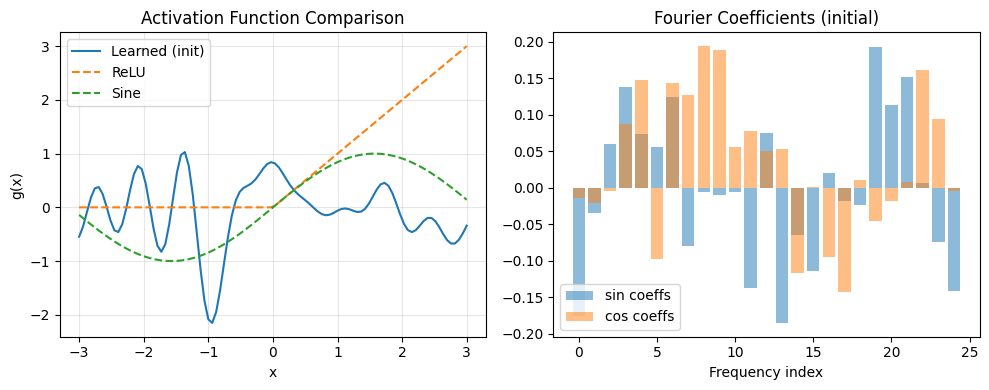

In [4]:
class LearnedActivation(nn.Module):
    """Fourier-parameterized learned activation function.

    g(x) = sum_k a_k * sin(w_k * x) + b_k * cos(w_k * x)

    Args:
        n_frequencies: Number of Fourier components (K)
        freq_init: How to initialize frequencies ('linear', 'log', 'random')
        learnable_freq: Whether frequencies are learnable
    """
    def __init__(self, n_frequencies=25, freq_init='linear', learnable_freq=False,
                 max_freq=10.0):
        super().__init__()
        self.n_frequencies = n_frequencies

        # Initialize frequencies
        if freq_init == 'linear':
            freqs = torch.linspace(0.1, max_freq, n_frequencies)
        elif freq_init == 'log':
            freqs = torch.logspace(-1, np.log10(max_freq), n_frequencies)
        else:  # random
            freqs = torch.rand(n_frequencies) * max_freq

        if learnable_freq:
            self.frequencies = nn.Parameter(freqs)
        else:
            self.register_buffer('frequencies', freqs)

        # Learnable coefficients for sin and cos
        # Initialize to approximate ReLU-like behavior
        self.sin_coeffs = nn.Parameter(torch.randn(n_frequencies) * 0.1)
        self.cos_coeffs = nn.Parameter(torch.randn(n_frequencies) * 0.1)

        # Learnable bias and scale
        self.bias = nn.Parameter(torch.zeros(1))
        self.scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        # x: any shape
        # Compute Fourier series
        # Shape: (*x.shape, n_frequencies)
        wx = x.unsqueeze(-1) * self.frequencies  # broadcast multiply

        sin_terms = torch.sin(wx) * self.sin_coeffs
        cos_terms = torch.cos(wx) * self.cos_coeffs

        # Sum over frequencies
        result = (sin_terms + cos_terms).sum(dim=-1)

        return self.scale * result + self.bias

    def num_params(self):
        return sum(p.numel() for p in self.parameters())


# Test
act = LearnedActivation(n_frequencies=25)
x = torch.linspace(-3, 3, 100)
y = act(x)
print(f"Learned activation params: {act.num_params()}")

# Visualize initial shape
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x.numpy(), y.detach().numpy(), label='Learned (init)')
plt.plot(x.numpy(), torch.relu(x).numpy(), '--', label='ReLU')
plt.plot(x.numpy(), torch.sin(x).numpy(), '--', label='Sine')
plt.legend()
plt.title('Activation Function Comparison')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(act.n_frequencies), act.sin_coeffs.detach().numpy(), alpha=0.5, label='sin coeffs')
plt.bar(range(act.n_frequencies), act.cos_coeffs.detach().numpy(), alpha=0.5, label='cos coeffs')
plt.legend()
plt.title('Fourier Coefficients (initial)')
plt.xlabel('Frequency index')
plt.tight_layout()
plt.show()

---
## 2. Spatially-Varying Activations (Mixture of Experts)

Different regions need different activation shapes:
- Urban: sharp boundaries
- Rural: smooth gradients  
- Agricultural: periodic patterns

We use a mixture of K expert activations, with weights from a gating network:

$$g^{(l)}(x; \lambda, \phi) = \sum_{m=1}^{M} w_m(\lambda, \phi) \cdot g_{\psi_l^m}(x)$$

Spatially-varying activation params: 5288


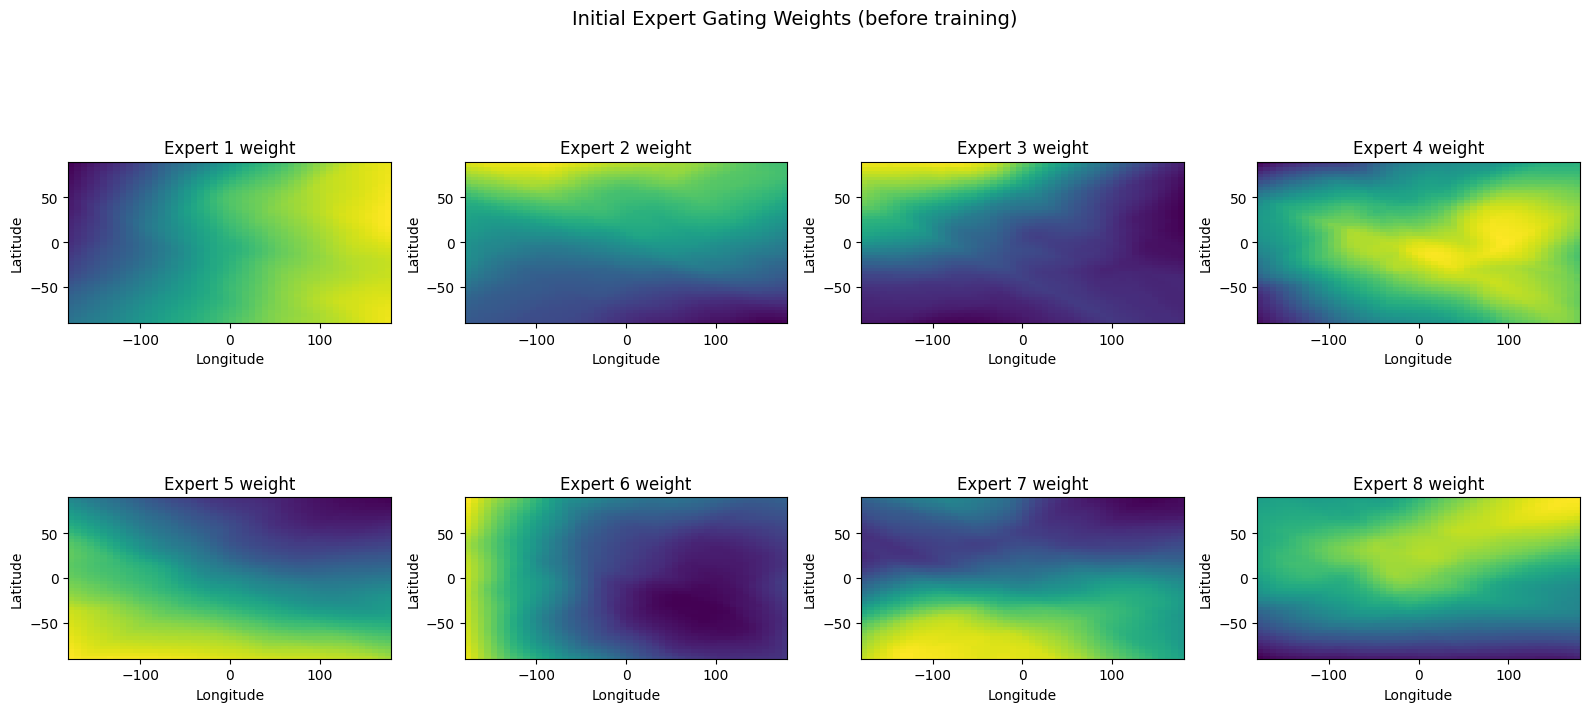

In [5]:
class SpatiallyVaryingActivation(nn.Module):
    """Mixture of expert activations with location-based gating.

    Args:
        n_experts: Number of expert activation functions
        n_frequencies: Frequencies per expert
        gate_hidden: Hidden dim for gating network
    """
    def __init__(self, n_experts=8, n_frequencies=25, gate_hidden=64):
        super().__init__()
        self.n_experts = n_experts

        # Create expert activations
        self.experts = nn.ModuleList([
            LearnedActivation(n_frequencies=n_frequencies)
            for _ in range(n_experts)
        ])

        # Gating network: (lat, lon) -> expert weights
        self.gate = nn.Sequential(
            nn.Linear(2, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, n_experts),
        )

    def forward(self, x, coords):
        """Apply spatially-varying activation.

        Args:
            x: Input tensor (batch, features) or (batch, seq, features)
            coords: Location (batch, 2) as (lon, lat) normalized to [-1, 1]

        Returns:
            Activated tensor, same shape as x
        """
        # Get gating weights
        weights = F.softmax(self.gate(coords), dim=-1)  # (batch, n_experts)

        # Apply each expert and combine
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=-1)  # (*x.shape, n_experts)

        # Reshape weights for broadcasting
        if x.dim() == 2:  # (batch, features)
            weights = weights.unsqueeze(1)  # (batch, 1, n_experts)
        elif x.dim() == 3:  # (batch, seq, features)
            weights = weights.unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, n_experts)

        # Weighted combination
        result = (expert_outputs * weights).sum(dim=-1)

        return result

    def get_expert_weights(self, coords):
        """Get expert weights for visualization."""
        with torch.no_grad():
            return F.softmax(self.gate(coords), dim=-1)

    def num_params(self):
        return sum(p.numel() for p in self.parameters())


# Test
spatial_act = SpatiallyVaryingActivation(n_experts=8, n_frequencies=25)
print(f"Spatially-varying activation params: {spatial_act.num_params()}")

# Visualize expert weights across globe
lons = torch.linspace(-1, 1, 50)
lats = torch.linspace(-1, 1, 50)
lon_grid, lat_grid = torch.meshgrid(lons, lats, indexing='xy')
coords = torch.stack([lon_grid.flatten(), lat_grid.flatten()], dim=1)

weights = spatial_act.get_expert_weights(coords)  # (2500, 8)
weights = weights.view(50, 50, 8)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(weights[:, :, i].numpy(), origin='lower', cmap='viridis',
                   extent=[-180, 180, -90, 90])
    ax.set_title(f'Expert {i+1} weight')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
plt.suptitle('Initial Expert Gating Weights (before training)', fontsize=14)
plt.tight_layout()
plt.show()

---
## 3. Location Encoder Architectures

We'll test several location encoder variants:
1. **Direct + ReLU**: Simple MLP baseline
2. **Direct + SIREN**: Sine activations (like SatCLIP)
3. **Direct + Learned**: Our learned activations
4. **Direct + Spatial**: Spatially-varying learned activations

In [6]:
class SineActivation(nn.Module):
    """Sine activation for SIREN networks."""
    def __init__(self, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * x)


class LocationEncoder(nn.Module):
    """Location encoder with configurable activation functions.

    Args:
        input_dim: Input dimension (2 for direct coords, or SH features)
        hidden_dim: Hidden layer dimension
        output_dim: Output embedding dimension
        n_layers: Number of hidden layers
        activation: 'relu', 'siren', 'learned', 'spatial'
        n_frequencies: For learned activations
        n_experts: For spatial activations
    """
    def __init__(self, input_dim=2, hidden_dim=256, output_dim=256, n_layers=3,
                 activation='relu', n_frequencies=25, n_experts=8):
        super().__init__()
        self.activation_type = activation
        self.n_layers = n_layers

        # Build layers
        layers = []
        dims = [input_dim] + [hidden_dim] * n_layers + [output_dim]

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))

        self.linears = nn.ModuleList(layers)

        # Create activations
        if activation == 'relu':
            self.activations = nn.ModuleList([nn.ReLU() for _ in range(n_layers)])
        elif activation == 'siren':
            self.activations = nn.ModuleList([SineActivation() for _ in range(n_layers)])
        elif activation == 'learned':
            self.activations = nn.ModuleList([
                LearnedActivation(n_frequencies=n_frequencies) for _ in range(n_layers)
            ])
        elif activation == 'spatial':
            self.activations = nn.ModuleList([
                SpatiallyVaryingActivation(n_experts=n_experts, n_frequencies=n_frequencies)
                for _ in range(n_layers)
            ])
        else:
            raise ValueError(f"Unknown activation: {activation}")

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for i, linear in enumerate(self.linears):
            if self.activation_type == 'siren':
                # SIREN initialization
                if i == 0:
                    nn.init.uniform_(linear.weight, -1/linear.in_features, 1/linear.in_features)
                else:
                    nn.init.uniform_(linear.weight,
                                    -np.sqrt(6/linear.in_features)/30,
                                    np.sqrt(6/linear.in_features)/30)
            else:
                nn.init.kaiming_normal_(linear.weight)
            nn.init.zeros_(linear.bias)

    def forward(self, coords):
        """Encode coordinates to embeddings.

        Args:
            coords: (batch, 2) as (lon, lat)

        Returns:
            embeddings: (batch, output_dim)
        """
        # Normalize coords to [-1, 1]
        x = coords.clone()
        x[:, 0] = x[:, 0] / 180.0  # lon
        x[:, 1] = x[:, 1] / 90.0   # lat

        # Store normalized coords for spatial activations
        norm_coords = x.clone()

        # Forward pass
        for i, (linear, act) in enumerate(zip(self.linears[:-1], self.activations)):
            x = linear(x)
            if self.activation_type == 'spatial':
                x = act(x, norm_coords)
            else:
                x = act(x)

        # Final linear (no activation)
        x = self.linears[-1](x)

        return x

    def num_params(self):
        return sum(p.numel() for p in self.parameters())


# Test all variants
print("Location Encoder Variants:")
print("-" * 50)
for act_type in ['relu', 'siren', 'learned', 'spatial']:
    model = LocationEncoder(activation=act_type)
    print(f"{act_type:10s}: {model.num_params():,} params")

# Test forward pass
coords = torch.randn(32, 2) * torch.tensor([180., 90.])
encoder = LocationEncoder(activation='spatial')
emb = encoder(coords)
print(f"\nOutput shape: {emb.shape}")

Location Encoder Variants:
--------------------------------------------------
relu      : 198,144 params
siren     : 198,144 params
learned   : 198,300 params
spatial   : 214,008 params

Output shape: torch.Size([32, 256])


---
## 4. Data Loading

In [7]:
# Load population data
Image.MAX_IMAGE_PIXELS = None

def load_gpw_raster(resolution='15_min', year=2020):
    """Load GPW population density raster."""
    tif_file = f"{GPW_DIR}/gpw_v4_population_density_rev11_{year}_{resolution}.tif"
    if not os.path.exists(tif_file):
        print(f"File not found: {tif_file}")
        return None, None

    img = Image.open(tif_file)
    data = np.array(img)
    height, width = data.shape

    lon_step = 360 / width
    lat_step = 180 / height
    lons = np.linspace(-180 + lon_step/2, 180 - lon_step/2, width)
    lats = np.linspace(90 - lat_step/2, -90 + lat_step/2, height)

    return data, (lons, lats)

def sample_from_raster(data, coords, n_samples=10000, seed=42, bounds=None):
    """Sample random valid points from population raster."""
    np.random.seed(seed)
    lons, lats = coords
    valid_mask = data > -1e30

    if bounds is not None:
        lon_min, lat_min, lon_max, lat_max = bounds
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        bounds_mask = (
            (lon_grid >= lon_min) & (lon_grid <= lon_max) &
            (lat_grid >= lat_min) & (lat_grid <= lat_max)
        )
        valid_mask = valid_mask & bounds_mask

    valid_idx = np.where(valid_mask)
    n_valid = len(valid_idx[0])

    if n_valid < n_samples:
        sample_idx = np.arange(n_valid)
    else:
        sample_idx = np.random.choice(n_valid, n_samples, replace=False)

    row_idx = valid_idx[0][sample_idx]
    col_idx = valid_idx[1][sample_idx]

    sample_lons = lons[col_idx]
    sample_lats = lats[row_idx]
    sample_values = data[row_idx, col_idx]

    coords_arr = np.stack([sample_lons, sample_lats], axis=1)
    return coords_arr, sample_values

# Load data
print("Loading population data...")
pop_data, pop_coords = load_gpw_raster('15_min')
print(f"Shape: {pop_data.shape}")

# Define regions
REGIONS = {
    'Global': None,
    'USA': (-125, 24, -66, 50),
    'Europe': (-10, 35, 40, 70),
    'China': (73, 18, 135, 54),
}

Loading population data...
Shape: (720, 1440)


In [8]:
class PopulationDataset(Dataset):
    """Dataset for population prediction."""
    def __init__(self, coords, values):
        self.coords = torch.tensor(coords, dtype=torch.float32)
        self.values = torch.tensor(np.log1p(values), dtype=torch.float32)  # Log transform

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        return self.coords[idx], self.values[idx]


def create_dataloaders(coords, values, test_size=0.5, batch_size=256, seed=42):
    """Create train/test dataloaders."""
    np.random.seed(seed)
    n = len(coords)
    indices = np.random.permutation(n)
    split = int(n * (1 - test_size))

    train_idx, test_idx = indices[:split], indices[split:]

    train_dataset = PopulationDataset(coords[train_idx], values[train_idx])
    test_dataset = PopulationDataset(coords[test_idx], values[test_idx])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

---
## 5. Training Infrastructure

In [9]:
class PopulationPredictor(nn.Module):
    """Full model: location encoder + prediction head."""
    def __init__(self, encoder, freeze_encoder=False):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, coords):
        emb = self.encoder(coords)
        return self.head(emb).squeeze(-1)


class SatCLIPPredictor(nn.Module):
    """Population predictor using frozen SatCLIP embeddings."""
    def __init__(self, satclip_model):
        super().__init__()
        self.satclip = satclip_model
        for param in self.satclip.parameters():
            param.requires_grad = False

        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, coords):
        with torch.no_grad():
            emb = self.satclip(coords.double()).float()
        return self.head(emb).squeeze(-1)


def train_model(model, train_loader, test_loader, epochs=50, lr=1e-3, device='cuda'):
    """Train model and return metrics."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    history = {'train_loss': [], 'test_loss': [], 'test_r2': []}

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for coords, targets in train_loader:
            coords, targets = coords.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(coords)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Evaluate
        model.eval()
        all_preds, all_targets = [], []
        test_loss = 0
        with torch.no_grad():
            for coords, targets in test_loader:
                coords, targets = coords.to(device), targets.to(device)
                outputs = model(coords)
                test_loss += criterion(outputs, targets).item()
                all_preds.append(outputs.cpu())
                all_targets.append(targets.cpu())

        test_loss /= len(test_loader)
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        # R² score
        ss_res = np.sum((all_targets - all_preds) ** 2)
        ss_tot = np.sum((all_targets - all_targets.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['test_r2'].append(r2)

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}, R²={r2:.4f}")

    return history

---
## 6. Run Experiments

In [10]:
print("="*80)
print("EXPERIMENT: Learned Activations vs SatCLIP")
print("="*80)

N_SAMPLES = 15000
EPOCHS = 50
BATCH_SIZE = 256

all_results = []

for region_name, bounds in REGIONS.items():
    print(f"\n{'─'*60}")
    print(f"Region: {region_name}")
    print(f"{'─'*60}")

    # Sample data
    coords, values = sample_from_raster(pop_data, pop_coords, n_samples=N_SAMPLES, bounds=bounds)
    print(f"Samples: {len(coords)}")

    if len(coords) < 1000:
        print("Skipping - too few samples")
        continue

    # Create dataloaders
    train_loader, test_loader = create_dataloaders(coords, values, batch_size=BATCH_SIZE)

    # Test different models
    models_to_test = {
        'SatCLIP L=10': lambda: SatCLIPPredictor(satclip_l10),
        'SatCLIP L=40': lambda: SatCLIPPredictor(satclip_l40),
        'Direct + ReLU': lambda: PopulationPredictor(LocationEncoder(activation='relu')),
        'Direct + SIREN': lambda: PopulationPredictor(LocationEncoder(activation='siren')),
        'Direct + Learned': lambda: PopulationPredictor(LocationEncoder(activation='learned', n_frequencies=25)),
        'Direct + Spatial (K=8)': lambda: PopulationPredictor(LocationEncoder(activation='spatial', n_experts=8)),
    }

    print(f"\n{'Model':<25} | {'R²':>8} | {'Params':>10}")
    print("-" * 50)

    for model_name, model_fn in models_to_test.items():
        print(f"Training {model_name}...")
        model = model_fn()
        n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        history = train_model(model, train_loader, test_loader, epochs=EPOCHS, device=device)
        final_r2 = history['test_r2'][-1]

        print(f"{model_name:<25} | {final_r2:>8.4f} | {n_params:>10,}")

        all_results.append({
            'region': region_name,
            'model': model_name,
            'r2': final_r2,
            'params': n_params,
            'history': history
        })

results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'history'} for r in all_results])
print(f"\n\nTotal experiments: {len(results_df)}")

EXPERIMENT: Learned Activations vs SatCLIP

────────────────────────────────────────────────────────────
Region: Global
────────────────────────────────────────────────────────────
Samples: 15000

Model                     |       R² |     Params
--------------------------------------------------
Training SatCLIP L=10...
  Epoch 10/50: train_loss=1.0322, test_loss=8.4929, R²=-1.2886
  Epoch 20/50: train_loss=0.9411, test_loss=7.8637, R²=-1.1183
  Epoch 30/50: train_loss=0.9111, test_loss=6.3696, R²=-0.7187
  Epoch 40/50: train_loss=0.9091, test_loss=5.4521, R²=-0.4728
  Epoch 50/50: train_loss=0.8347, test_loss=5.2458, R²=-0.4163
SatCLIP L=10              |  -0.4163 |     33,025
Training SatCLIP L=40...
  Epoch 10/50: train_loss=1.2239, test_loss=10.7867, R²=-1.9108
  Epoch 20/50: train_loss=1.1256, test_loss=9.1921, R²=-1.4815
  Epoch 30/50: train_loss=1.1000, test_loss=9.8372, R²=-1.6582
  Epoch 40/50: train_loss=1.0406, test_loss=7.6117, R²=-1.0570
  Epoch 50/50: train_loss=1.0323, 


RESULTS: R² by Model and Region
region                  China  Europe  Global    USA
model                                               
Direct + Learned        0.892   0.728   0.797  0.547
Direct + ReLU           0.799   0.537   0.713  0.442
Direct + SIREN         -0.017  -0.007  -0.009 -0.011
Direct + Spatial (K=8)  0.900   0.706   0.791  0.566
SatCLIP L=10           -0.261  -0.743  -0.416 -0.348
SatCLIP L=40           -1.903  -3.708  -0.959 -1.307


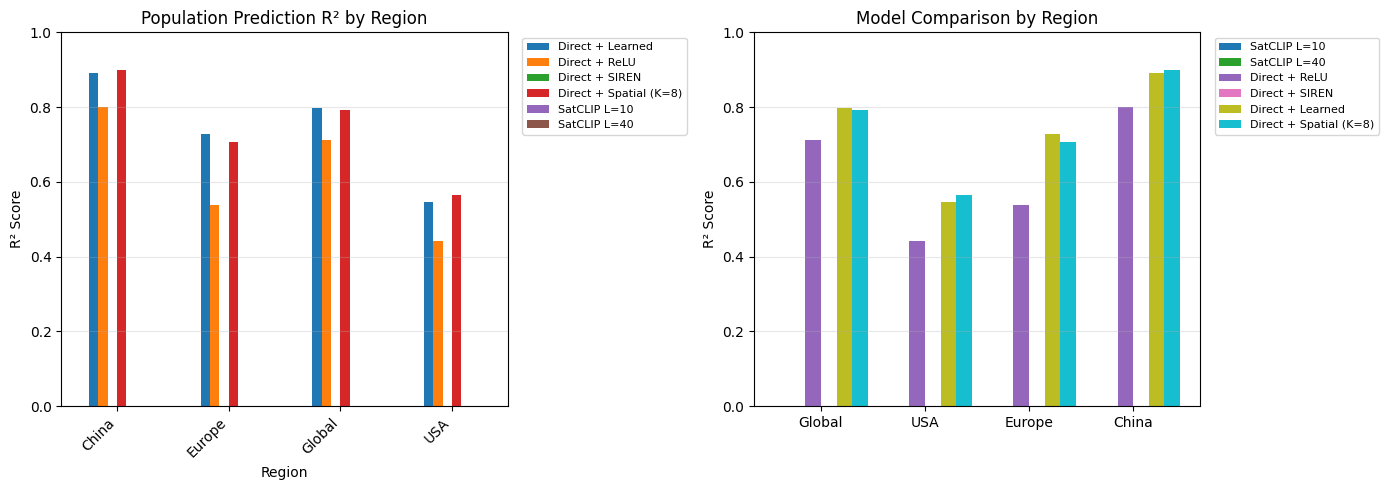

In [11]:
# Visualize results
if len(results_df) > 0:
    # Pivot table
    pivot = results_df.pivot(index='model', columns='region', values='r2')

    print("\n" + "="*70)
    print("RESULTS: R² by Model and Region")
    print("="*70)
    print(pivot.round(3).to_string())

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart by region
    ax = axes[0]
    pivot.T.plot(kind='bar', ax=ax)
    ax.set_ylabel('R² Score')
    ax.set_xlabel('Region')
    ax.set_title('Population Prediction R² by Region')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Compare SatCLIP vs Ours
    ax = axes[1]
    regions = results_df['region'].unique()
    x = np.arange(len(regions))
    width = 0.15

    models_order = ['SatCLIP L=10', 'SatCLIP L=40', 'Direct + ReLU', 'Direct + SIREN', 'Direct + Learned', 'Direct + Spatial (K=8)']
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_order)))

    for i, model in enumerate(models_order):
        model_data = results_df[results_df['model'] == model]
        if len(model_data) > 0:
            r2_vals = [model_data[model_data['region'] == r]['r2'].values[0] if len(model_data[model_data['region'] == r]) > 0 else 0 for r in regions]
            ax.bar(x + i*width, r2_vals, width, label=model, color=colors[i])

    ax.set_xticks(x + width * (len(models_order)-1) / 2)
    ax.set_xticklabels(regions)
    ax.set_ylabel('R² Score')
    ax.set_title('Model Comparison by Region')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('learned_activations_results.png', dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
# Analyze: Can learned activations match SatCLIP?
print("="*70)
print("ANALYSIS: Learned Activations vs SatCLIP")
print("="*70)

if len(results_df) > 0:
    for region in results_df['region'].unique():
        region_data = results_df[results_df['region'] == region]

        satclip_l10 = region_data[region_data['model'] == 'SatCLIP L=10']['r2'].values
        satclip_l40 = region_data[region_data['model'] == 'SatCLIP L=40']['r2'].values
        learned = region_data[region_data['model'] == 'Direct + Learned']['r2'].values
        spatial = region_data[region_data['model'] == 'Direct + Spatial (K=8)']['r2'].values

        if len(satclip_l10) > 0 and len(learned) > 0:
            print(f"\n{region}:")
            print(f"  SatCLIP L=10: {satclip_l10[0]:.3f}")
            print(f"  SatCLIP L=40: {satclip_l40[0]:.3f}" if len(satclip_l40) > 0 else "  SatCLIP L=40: N/A")
            print(f"  Learned:      {learned[0]:.3f} (vs L=10: {learned[0] - satclip_l10[0]:+.3f})")
            print(f"  Spatial:      {spatial[0]:.3f} (vs L=10: {spatial[0] - satclip_l10[0]:+.3f})" if len(spatial) > 0 else "")

ANALYSIS: Learned Activations vs SatCLIP

Global:
  SatCLIP L=10: -0.416
  SatCLIP L=40: -0.959
  Learned:      0.797 (vs L=10: +1.214)
  Spatial:      0.791 (vs L=10: +1.207)

USA:
  SatCLIP L=10: -0.348
  SatCLIP L=40: -1.307
  Learned:      0.547 (vs L=10: +0.896)
  Spatial:      0.566 (vs L=10: +0.914)

Europe:
  SatCLIP L=10: -0.743
  SatCLIP L=40: -3.708
  Learned:      0.728 (vs L=10: +1.472)
  Spatial:      0.706 (vs L=10: +1.449)

China:
  SatCLIP L=10: -0.261
  SatCLIP L=40: -1.903
  Learned:      0.892 (vs L=10: +1.153)
  Spatial:      0.900 (vs L=10: +1.161)


---
## 7. Visualize Learned Activations

Training model to visualize learned activations...
  Epoch 10/50: train_loss=0.6674, test_loss=0.7958, R²=0.7827
  Epoch 20/50: train_loss=0.6355, test_loss=0.7896, R²=0.7845
  Epoch 30/50: train_loss=0.5801, test_loss=0.7840, R²=0.7857
  Epoch 40/50: train_loss=0.5548, test_loss=0.7813, R²=0.7864
  Epoch 50/50: train_loss=0.5058, test_loss=0.8100, R²=0.7786


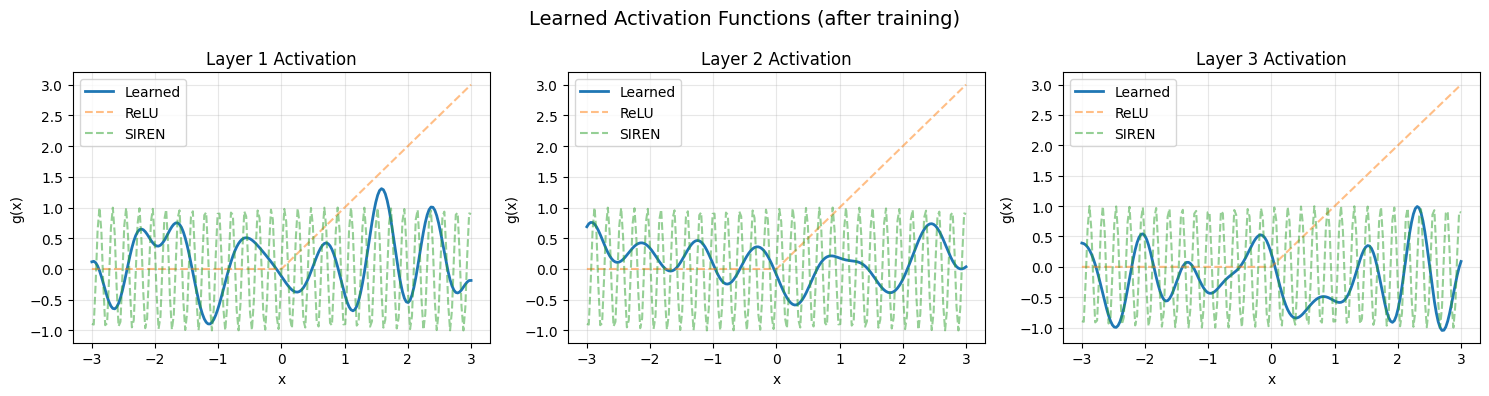

In [13]:
# Train a model and visualize the learned activations
print("Training model to visualize learned activations...")

# Sample global data
coords, values = sample_from_raster(pop_data, pop_coords, n_samples=15000, bounds=None)
train_loader, test_loader = create_dataloaders(coords, values, batch_size=256)

# Train learned activation model
encoder = LocationEncoder(activation='learned', n_frequencies=25, n_layers=3)
model = PopulationPredictor(encoder)
history = train_model(model, train_loader, test_loader, epochs=50, device=device)

# Visualize learned activations
x = torch.linspace(-3, 3, 200)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, act in enumerate(encoder.activations):
    y = act(x.to(device)).cpu().detach().numpy()
    axes[i].plot(x.numpy(), y, linewidth=2, label='Learned')
    axes[i].plot(x.numpy(), torch.relu(x).numpy(), '--', alpha=0.5, label='ReLU')
    axes[i].plot(x.numpy(), torch.sin(30*x).numpy(), '--', alpha=0.5, label='SIREN')
    axes[i].set_title(f'Layer {i+1} Activation')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('g(x)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Learned Activation Functions (after training)', fontsize=14)
plt.tight_layout()
plt.savefig('learned_activations_shapes.png', dpi=150)
plt.show()

Training spatial model to visualize expert weights...
  Epoch 10/50: train_loss=0.7023, test_loss=0.8142, R²=0.7776
  Epoch 20/50: train_loss=0.6087, test_loss=0.7756, R²=0.7874
  Epoch 30/50: train_loss=0.5498, test_loss=0.7709, R²=0.7894
  Epoch 40/50: train_loss=0.5217, test_loss=0.7490, R²=0.7950
  Epoch 50/50: train_loss=0.4569, test_loss=0.7113, R²=0.8058


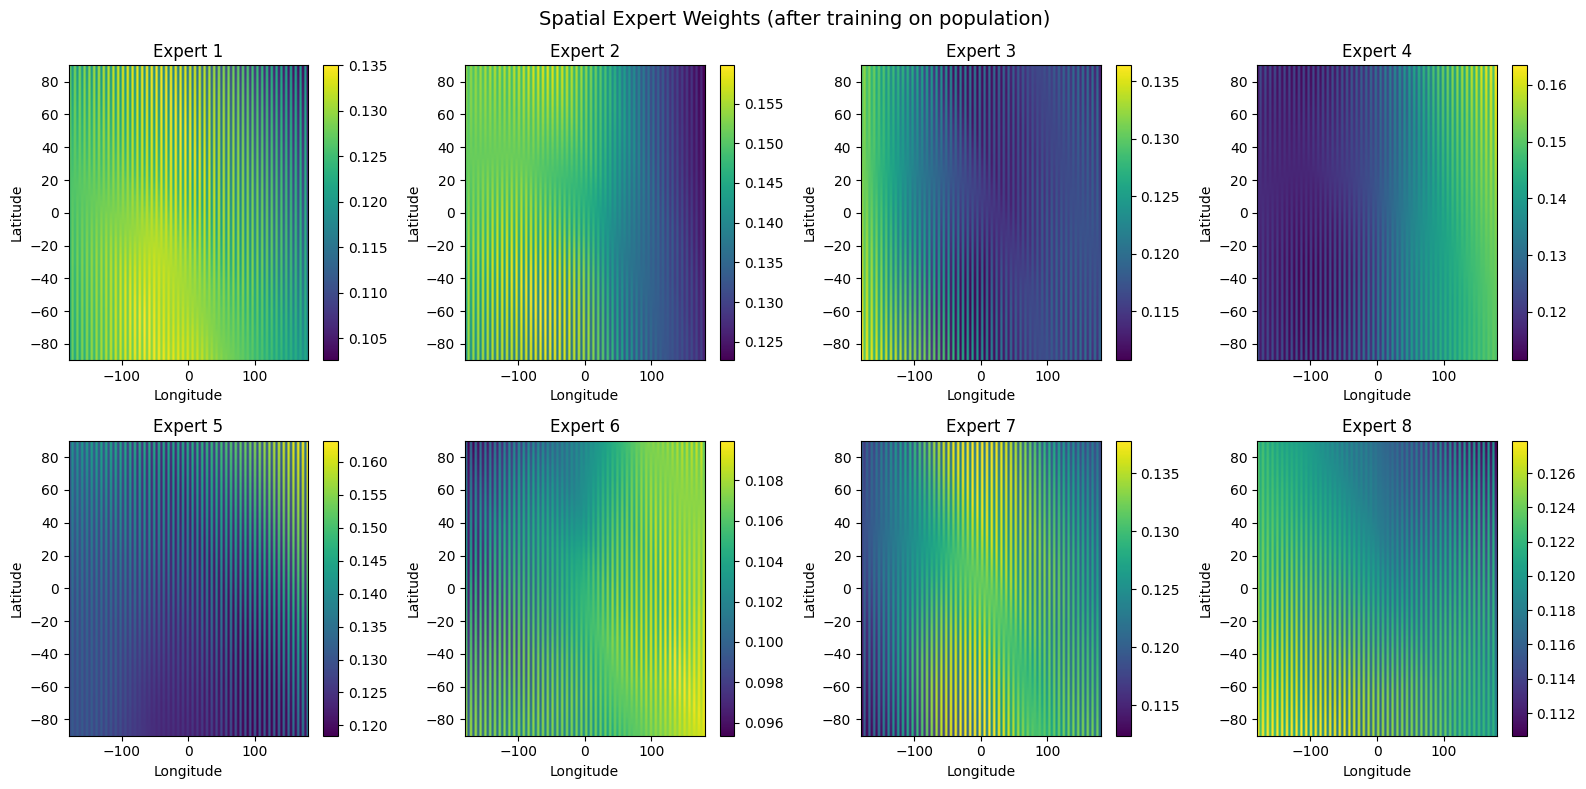

In [14]:
# Visualize spatial activation expert weights (after training)
print("Training spatial model to visualize expert weights...")

encoder_spatial = LocationEncoder(activation='spatial', n_experts=8, n_frequencies=25)
model_spatial = PopulationPredictor(encoder_spatial)
history_spatial = train_model(model_spatial, train_loader, test_loader, epochs=50, device=device)

# Get expert weights across the globe
lons = torch.linspace(-180, 180, 100)
lats = torch.linspace(-90, 90, 50)
lon_grid, lat_grid = torch.meshgrid(lons, lats, indexing='xy')
coords_grid = torch.stack([lon_grid.flatten(), lat_grid.flatten()], dim=1)

# Normalize coords
norm_coords = coords_grid.clone()
norm_coords[:, 0] = norm_coords[:, 0] / 180.0
norm_coords[:, 1] = norm_coords[:, 1] / 90.0

# Get weights from first layer
spatial_act = encoder_spatial.activations[0].to(device)
weights = spatial_act.get_expert_weights(norm_coords.to(device)).cpu()
weights = weights.view(100, 50, 8).permute(1, 0, 2)  # (lat, lon, experts)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(weights[:, :, i].numpy(), origin='lower', cmap='viridis',
                   extent=[-180, 180, -90, 90], aspect='auto')
    ax.set_title(f'Expert {i+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax)

plt.suptitle('Spatial Expert Weights (after training on population)', fontsize=14)
plt.tight_layout()
plt.savefig('spatial_expert_weights.png', dpi=150)
plt.show()

In [15]:
# Save results
if len(results_df) > 0:
    results_df.to_csv('learned_activations_results.csv', index=False)
    print("Results saved to learned_activations_results.csv")

    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(results_df.pivot(index='model', columns='region', values='r2').round(3).to_string())

Results saved to learned_activations_results.csv

SUMMARY
region                  China  Europe  Global    USA
model                                               
Direct + Learned        0.892   0.728   0.797  0.547
Direct + ReLU           0.799   0.537   0.713  0.442
Direct + SIREN         -0.017  -0.007  -0.009 -0.011
Direct + Spatial (K=8)  0.900   0.706   0.791  0.566
SatCLIP L=10           -0.261  -0.743  -0.416 -0.348
SatCLIP L=40           -1.903  -3.708  -0.959 -1.307


---
## 8. Next Steps

Based on these initial results, here's what to try next:

### If Learned Activations Work Well:
1. **Scale up**: More frequencies, more experts, deeper networks
2. **Contrastive pretraining**: Train full SatCLIP-style with image-location pairs
3. **Multi-task**: Test on temperature, elevation, land cover

### If They Don't Match SatCLIP:
1. **Hybrid approach**: Use spherical harmonics BUT with learned activations
2. **Different parameterization**: Try B-splines, wavelets, or other basis functions
3. **Architecture search**: More layers, residual connections, attention

### Key Experiments:
1. **Regional advantage**: Does spatial varying help more in regional tasks?
2. **Parameter efficiency**: Can we match L=40 with fewer params?
3. **Activation visualization**: What shapes do the learned activations converge to?